# Primordial Atom Breakup: Early Training Dynamics

**How does the initial cluster of identical token embeddings break apart during early training?**

At initialization, all 128 token embeddings are essentially identical—the "primordial atom." During the first ~20 steps of smooth SGD training, this cluster begins to dissolve. We're looking for the mechanism:

1. **One-by-one sublimation:** Tokens escape individually, orderly, preserving cluster structure
2. **Brownian evaporation:** Thermal diffusion, random directions, uncorrelated motion  
3. **Coherent expansion:** All tokens moving together in some structured way

## Metrics

1. **Cluster radius:** Distance from each token to centroid over time
2. **Pairwise distances:** How fast does structure emerge in the distance matrix?
3. **Displacement coherence:** Are token movements parallel, random, or sparse?
4. **Effective movers:** How many tokens have moved significantly?
5. **Neighbor preservation:** Do initially-close tokens stay close?

## Parameters

In [19]:
# Data source
TRAINING_DATA_PATH = '../tensors/Lil_Gatsby/1.9d_training_data.safetensors'
RUN_NAME = '1.9d (vanilla SGD, lr=0.1, batch=1)'

# Analysis window
ANALYSIS_STEPS = list(range(0, 21))  # Steps 0-20 (init + first 20 updates)

# Thresholds
SIGNIFICANT_MOVEMENT = 0.01  # Consider token "moved" if distance > this

# Visualization
DPI = 200
COLORMAP = 'inferno'

## Imports

In [20]:
import torch
import numpy as np
from safetensors.torch import load_file
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr

## Device Detection

In [21]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f'Using device: {device}')

Using device: mps


## Load Data

In [22]:
data = load_file(TRAINING_DATA_PATH)
embeddings = data['embeddings']  # (n_steps, 128, 64)

print(f'Loaded: {RUN_NAME}')
print(f'Embeddings shape: {embeddings.shape}')
print(f'Steps available: {embeddings.shape[0]}')
print(f'Vocab size: {embeddings.shape[1]}')
print(f'Embedding dim: {embeddings.shape[2]}')
print()
print(f'Analyzing steps: {ANALYSIS_STEPS[0]}-{ANALYSIS_STEPS[-1]}')

Loaded: 1.9d (vanilla SGD, lr=0.1, batch=1)
Embeddings shape: torch.Size([1001, 128, 64])
Steps available: 1001
Vocab size: 128
Embedding dim: 64

Analyzing steps: 0-20


## 1. Cluster Radius Evolution

In [23]:
print('Computing cluster radius over time...')
print()

n_steps = len(ANALYSIS_STEPS)
n_tokens = embeddings.shape[1]

# Store radius for each token at each step
radius = np.zeros((n_steps, n_tokens))

for i, step in enumerate(ANALYSIS_STEPS):
    emb = embeddings[step].cpu().numpy()  # (128, 64)
    
    # Centroid
    centroid = emb.mean(axis=0)  # (64,)
    
    # Distance from each token to centroid
    distances = np.linalg.norm(emb - centroid, axis=1)  # (128,)
    radius[i] = distances

print(f'✓ Computed radius for {n_steps} steps, {n_tokens} tokens')

Computing cluster radius over time...

✓ Computed radius for 21 steps, 128 tokens


In [24]:
# Summary statistics
print('='*70)
print('CLUSTER RADIUS SUMMARY')
print('='*70)
print()
print(f'Initial (step {ANALYSIS_STEPS[0]}):')
print(f'  Mean radius: {radius[0].mean():.6f}')
print(f'  Std radius: {radius[0].std():.6f}')
print(f'  Min radius: {radius[0].min():.6f}')
print(f'  Max radius: {radius[0].max():.6f}')
print()

print(f'Final (step {ANALYSIS_STEPS[-1]}):')
print(f'  Mean radius: {radius[-1].mean():.6f}')
print(f'  Std radius: {radius[-1].std():.6f}')
print(f'  Min radius: {radius[-1].min():.6f}')
print(f'  Max radius: {radius[-1].max():.6f}')
print()

print('Change (final - initial):')
print(f'  Δ Mean radius: {radius[-1].mean() - radius[0].mean():+.6f}')
print(f'  Δ Std radius: {radius[-1].std() - radius[0].std():+.6f}')
print('='*70)

CLUSTER RADIUS SUMMARY

Initial (step 0):
  Mean radius: 0.000285
  Std radius: 0.000069
  Min radius: 0.000227
  Max radius: 0.000554

Final (step 20):
  Mean radius: 0.081705
  Std radius: 0.082767
  Min radius: 0.011132
  Max radius: 0.445659

Change (final - initial):
  Δ Mean radius: +0.081421
  Δ Std radius: +0.082699


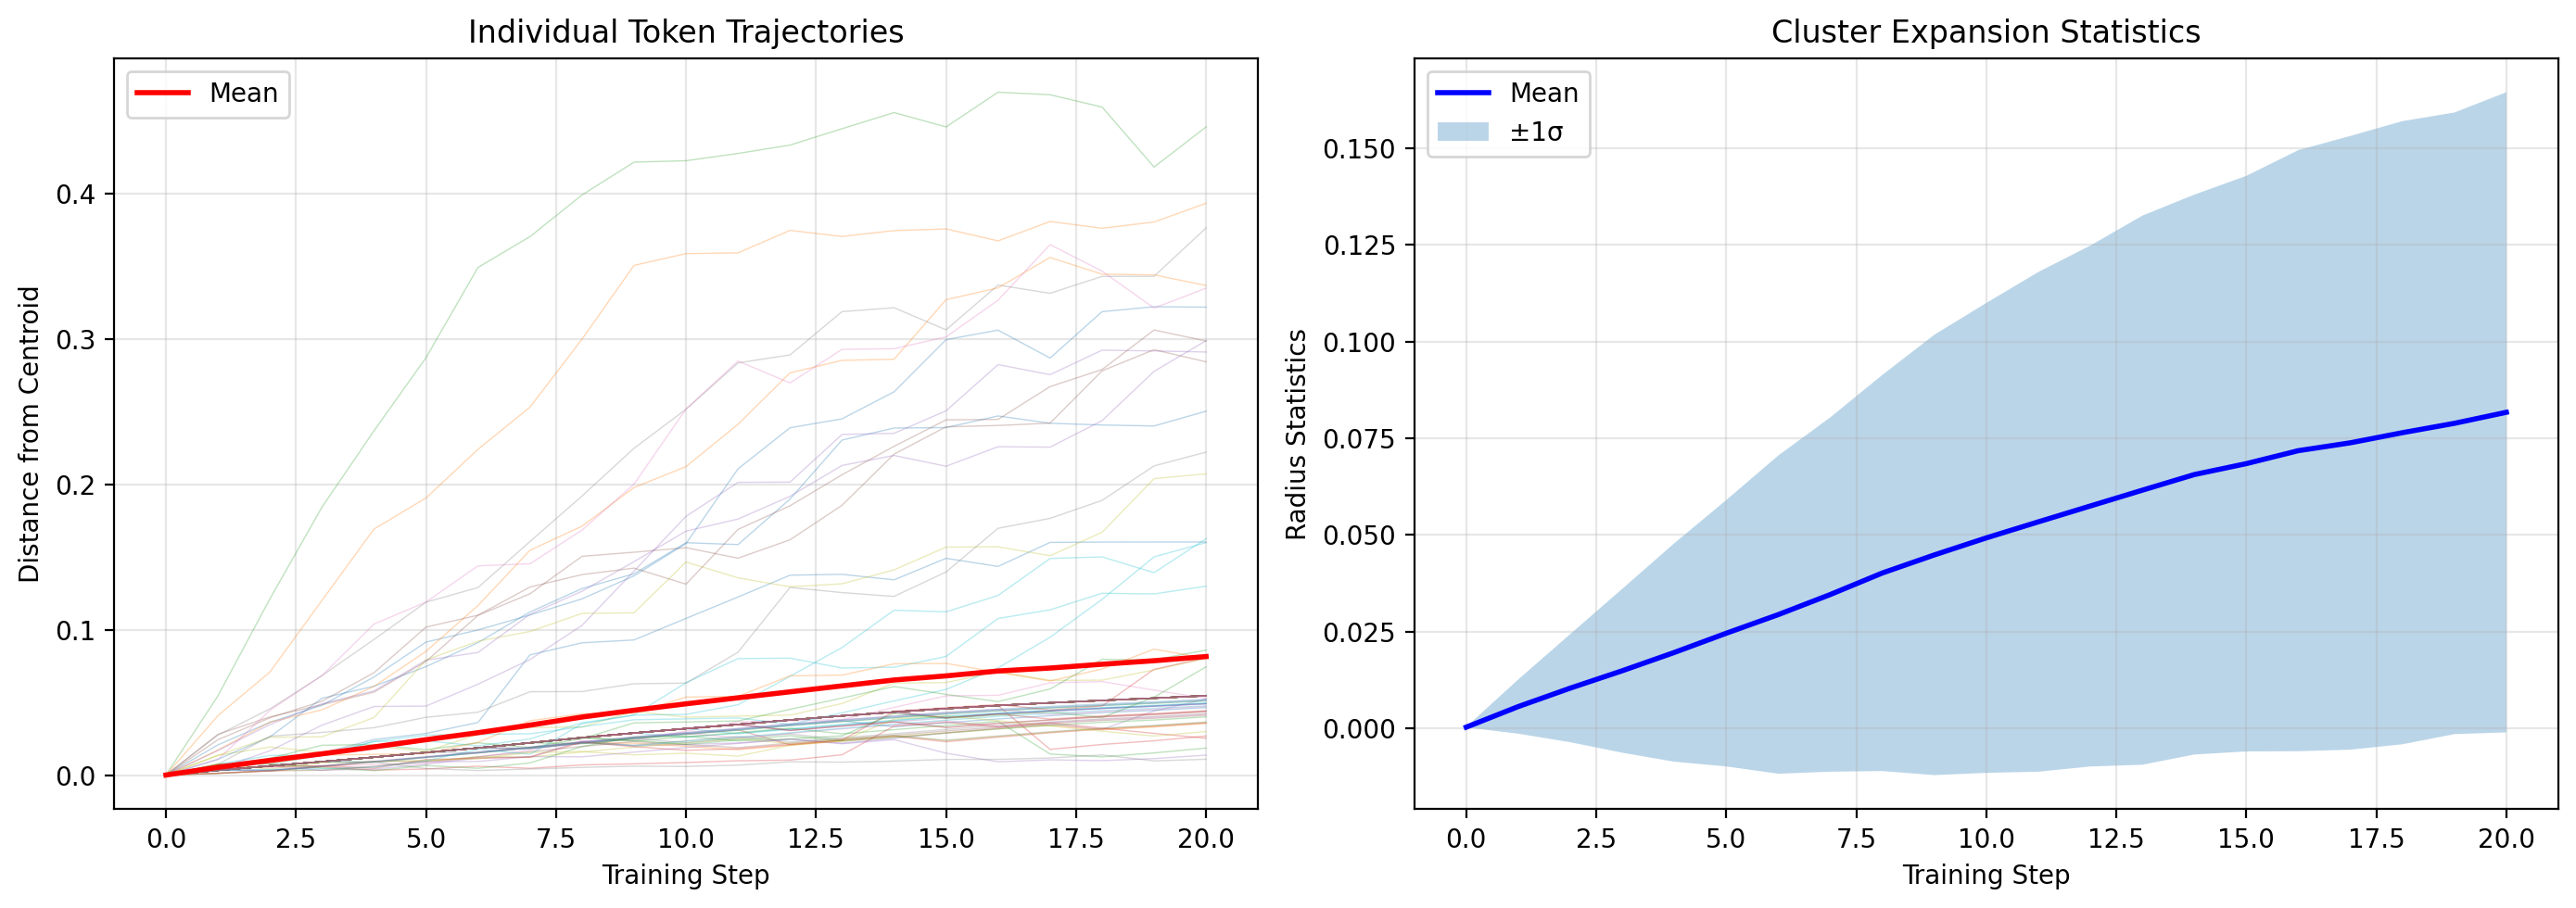

In [25]:
# Plot: radius trajectories for all tokens
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=DPI)

# Left: Individual trajectories (spaghetti plot)
ax = axes[0]
for tok_idx in range(n_tokens):
    ax.plot(ANALYSIS_STEPS, radius[:, tok_idx], alpha=0.3, linewidth=0.5)

# Overlay mean
ax.plot(ANALYSIS_STEPS, radius.mean(axis=1), 'r-', linewidth=2, label='Mean')
ax.set_xlabel('Training Step')
ax.set_ylabel('Distance from Centroid')
ax.set_title('Individual Token Trajectories')
ax.legend()
ax.grid(alpha=0.3)

# Right: Statistics over time
ax = axes[1]
mean_r = radius.mean(axis=1)
std_r = radius.std(axis=1)
ax.plot(ANALYSIS_STEPS, mean_r, 'b-', linewidth=2, label='Mean')
ax.fill_between(ANALYSIS_STEPS, mean_r - std_r, mean_r + std_r, alpha=0.3, label='±1σ')
ax.set_xlabel('Training Step')
ax.set_ylabel('Radius Statistics')
ax.set_title('Cluster Expansion Statistics')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Pairwise Distance Growth

In [26]:
print('Computing pairwise distance evolution...')
print()

# Pick a few snapshot steps
snapshot_steps = [0, 5, 10, 20]
snapshot_indices = [ANALYSIS_STEPS.index(s) for s in snapshot_steps if s in ANALYSIS_STEPS]

# Compute distance matrices
dist_matrices = []
for step_idx in snapshot_indices:
    step = ANALYSIS_STEPS[step_idx]
    emb = embeddings[step].cpu().numpy()
    
    # Pairwise distances
    dist_vec = pdist(emb, metric='euclidean')
    dist_mat = squareform(dist_vec)
    dist_matrices.append(dist_mat)

print(f'✓ Computed distance matrices for steps: {[ANALYSIS_STEPS[i] for i in snapshot_indices]}')

Computing pairwise distance evolution...

✓ Computed distance matrices for steps: [0, 5, 10, 20]


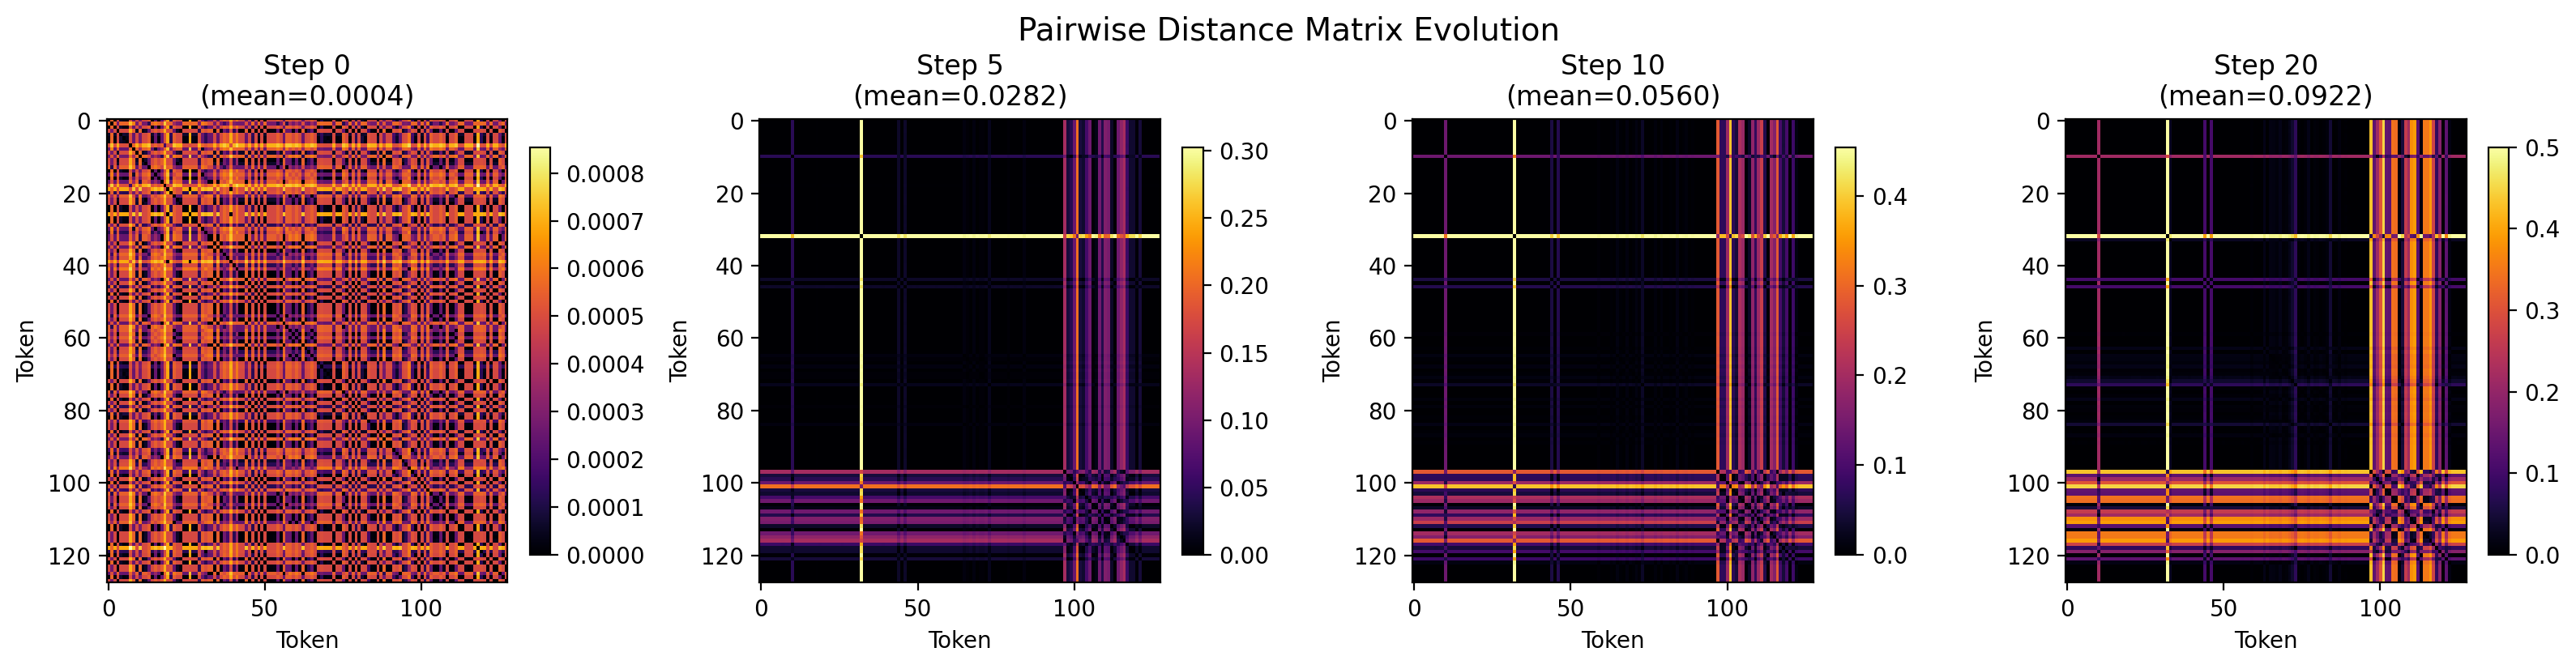

In [27]:
# Visualize distance matrix heatmaps
fig, axes = plt.subplots(1, len(snapshot_indices), figsize=(4*len(snapshot_indices), 4), dpi=DPI)

if len(snapshot_indices) == 1:
    axes = [axes]

for i, (step_idx, dist_mat) in enumerate(zip(snapshot_indices, dist_matrices)):
    step = ANALYSIS_STEPS[step_idx]
    ax = axes[i]
    
    im = ax.imshow(dist_mat, cmap=COLORMAP, aspect='auto')
    ax.set_title(f'Step {step}\n(mean={dist_mat.mean():.4f})')
    ax.set_xlabel('Token')
    ax.set_ylabel('Token')
    plt.colorbar(im, ax=ax, fraction=0.046)

plt.tight_layout()
plt.suptitle('Pairwise Distance Matrix Evolution', y=1.02, fontsize=14)
plt.show()

In [28]:
# Distance growth statistics
print('='*70)
print('PAIRWISE DISTANCE STATISTICS')
print('='*70)
print()

for i, (step_idx, dist_mat) in enumerate(zip(snapshot_indices, dist_matrices)):
    step = ANALYSIS_STEPS[step_idx]
    
    # Only upper triangle (no diagonal)
    upper_tri = dist_mat[np.triu_indices_from(dist_mat, k=1)]
    
    print(f'Step {step}:')
    print(f'  Mean distance: {upper_tri.mean():.6f}')
    print(f'  Std distance: {upper_tri.std():.6f}')
    print(f'  Min distance: {upper_tri.min():.6f}')
    print(f'  Max distance: {upper_tri.max():.6f}')
    print(f'  Median distance: {np.median(upper_tri):.6f}')
    print()

print('='*70)

PAIRWISE DISTANCE STATISTICS

Step 0:
  Mean distance: 0.000356
  Std distance: 0.000214
  Min distance: 0.000000
  Max distance: 0.000855
  Median distance: 0.000488

Step 5:
  Mean distance: 0.028376
  Std distance: 0.052942
  Min distance: 0.000000
  Max distance: 0.302859
  Median distance: 0.001109

Step 10:
  Mean distance: 0.056488
  Std distance: 0.095573
  Min distance: 0.000000
  Max distance: 0.454520
  Median distance: 0.004443

Step 20:
  Mean distance: 0.092900
  Std distance: 0.136510
  Min distance: 0.000000
  Max distance: 0.500152
  Median distance: 0.011801



## 3. Displacement Coherence

In [29]:
print('Computing displacement vectors and coherence...')
print()

# For each step t, compute displacement: emb[t] - emb[t-1]
# Then measure how parallel/random these displacements are

coherence_results = []

for i in range(1, len(ANALYSIS_STEPS)):
    step_prev = ANALYSIS_STEPS[i-1]
    step_curr = ANALYSIS_STEPS[i]
    
    emb_prev = embeddings[step_prev].cpu().numpy()
    emb_curr = embeddings[step_curr].cpu().numpy()
    
    # Displacement vectors for all tokens
    displacements = emb_curr - emb_prev  # (128, 64)
    
    # Magnitude of each displacement
    magnitudes = np.linalg.norm(displacements, axis=1)  # (128,)
    
    # Normalize to get directions (avoid div by zero)
    directions = np.zeros_like(displacements)
    mask = magnitudes > 1e-12
    directions[mask] = displacements[mask] / magnitudes[mask, np.newaxis]
    
    # Pairwise cosine similarities of displacement directions
    # (Only for tokens that moved significantly)
    moving_mask = magnitudes > 1e-6
    if moving_mask.sum() > 1:
        moving_directions = directions[moving_mask]
        
        # Compute all pairwise cosines
        cosines = moving_directions @ moving_directions.T
        
        # Upper triangle only
        upper_tri = cosines[np.triu_indices_from(cosines, k=1)]
        
        mean_cosine = upper_tri.mean()
        std_cosine = upper_tri.std()
    else:
        mean_cosine = np.nan
        std_cosine = np.nan
    
    coherence_results.append({
        'step': step_curr,
        'mean_magnitude': magnitudes.mean(),
        'std_magnitude': magnitudes.std(),
        'n_moving': moving_mask.sum(),
        'mean_cosine': mean_cosine,
        'std_cosine': std_cosine,
    })

print(f'✓ Computed displacement coherence for {len(coherence_results)} step transitions')

Computing displacement vectors and coherence...

✓ Computed displacement coherence for 20 step transitions


In [30]:
# Summary
print('='*70)
print('DISPLACEMENT COHERENCE SUMMARY')
print('='*70)
print()
print('For each step transition, we compute:')
print('  - Displacement vectors (emb[t] - emb[t-1])')
print('  - Pairwise cosine similarities of displacement directions')
print()
print('Interpretation:')
print('  - Mean cosine ≈ 1.0  → coherent (all tokens moving same direction)')
print('  - Mean cosine ≈ 0.0  → random/thermal (uncorrelated directions)')
print('  - Mean cosine ≈ -1.0 → divergent (tokens moving opposite directions)')
print()

for res in coherence_results[:10]:  # Show first 10
    print(f"Step {res['step']}:")
    print(f"  Moving tokens: {res['n_moving']}/128")
    print(f"  Mean displacement: {res['mean_magnitude']:.6f}")
    print(f"  Mean cosine: {res['mean_cosine']:.6f}")
    print()

if len(coherence_results) > 10:
    print(f'... ({len(coherence_results) - 10} more steps)')
    print()

print('='*70)

DISPLACEMENT COHERENCE SUMMARY

For each step transition, we compute:
  - Displacement vectors (emb[t] - emb[t-1])
  - Pairwise cosine similarities of displacement directions

Interpretation:
  - Mean cosine ≈ 1.0  → coherent (all tokens moving same direction)
  - Mean cosine ≈ 0.0  → random/thermal (uncorrelated directions)
  - Mean cosine ≈ -1.0 → divergent (tokens moving opposite directions)

Step 1:
  Moving tokens: 128/128
  Mean displacement: 0.005920
  Mean cosine: 0.387212

Step 2:
  Moving tokens: 128/128
  Mean displacement: 0.005524
  Mean cosine: 0.480632

Step 3:
  Moving tokens: 128/128
  Mean displacement: 0.005214
  Mean cosine: 0.453414

Step 4:
  Moving tokens: 128/128
  Mean displacement: 0.005401
  Mean cosine: 0.443178

Step 5:
  Moving tokens: 128/128
  Mean displacement: 0.005734
  Mean cosine: 0.441751

Step 6:
  Moving tokens: 128/128
  Mean displacement: 0.005484
  Mean cosine: 0.425714

Step 7:
  Moving tokens: 128/128
  Mean displacement: 0.005857
  Mean cos

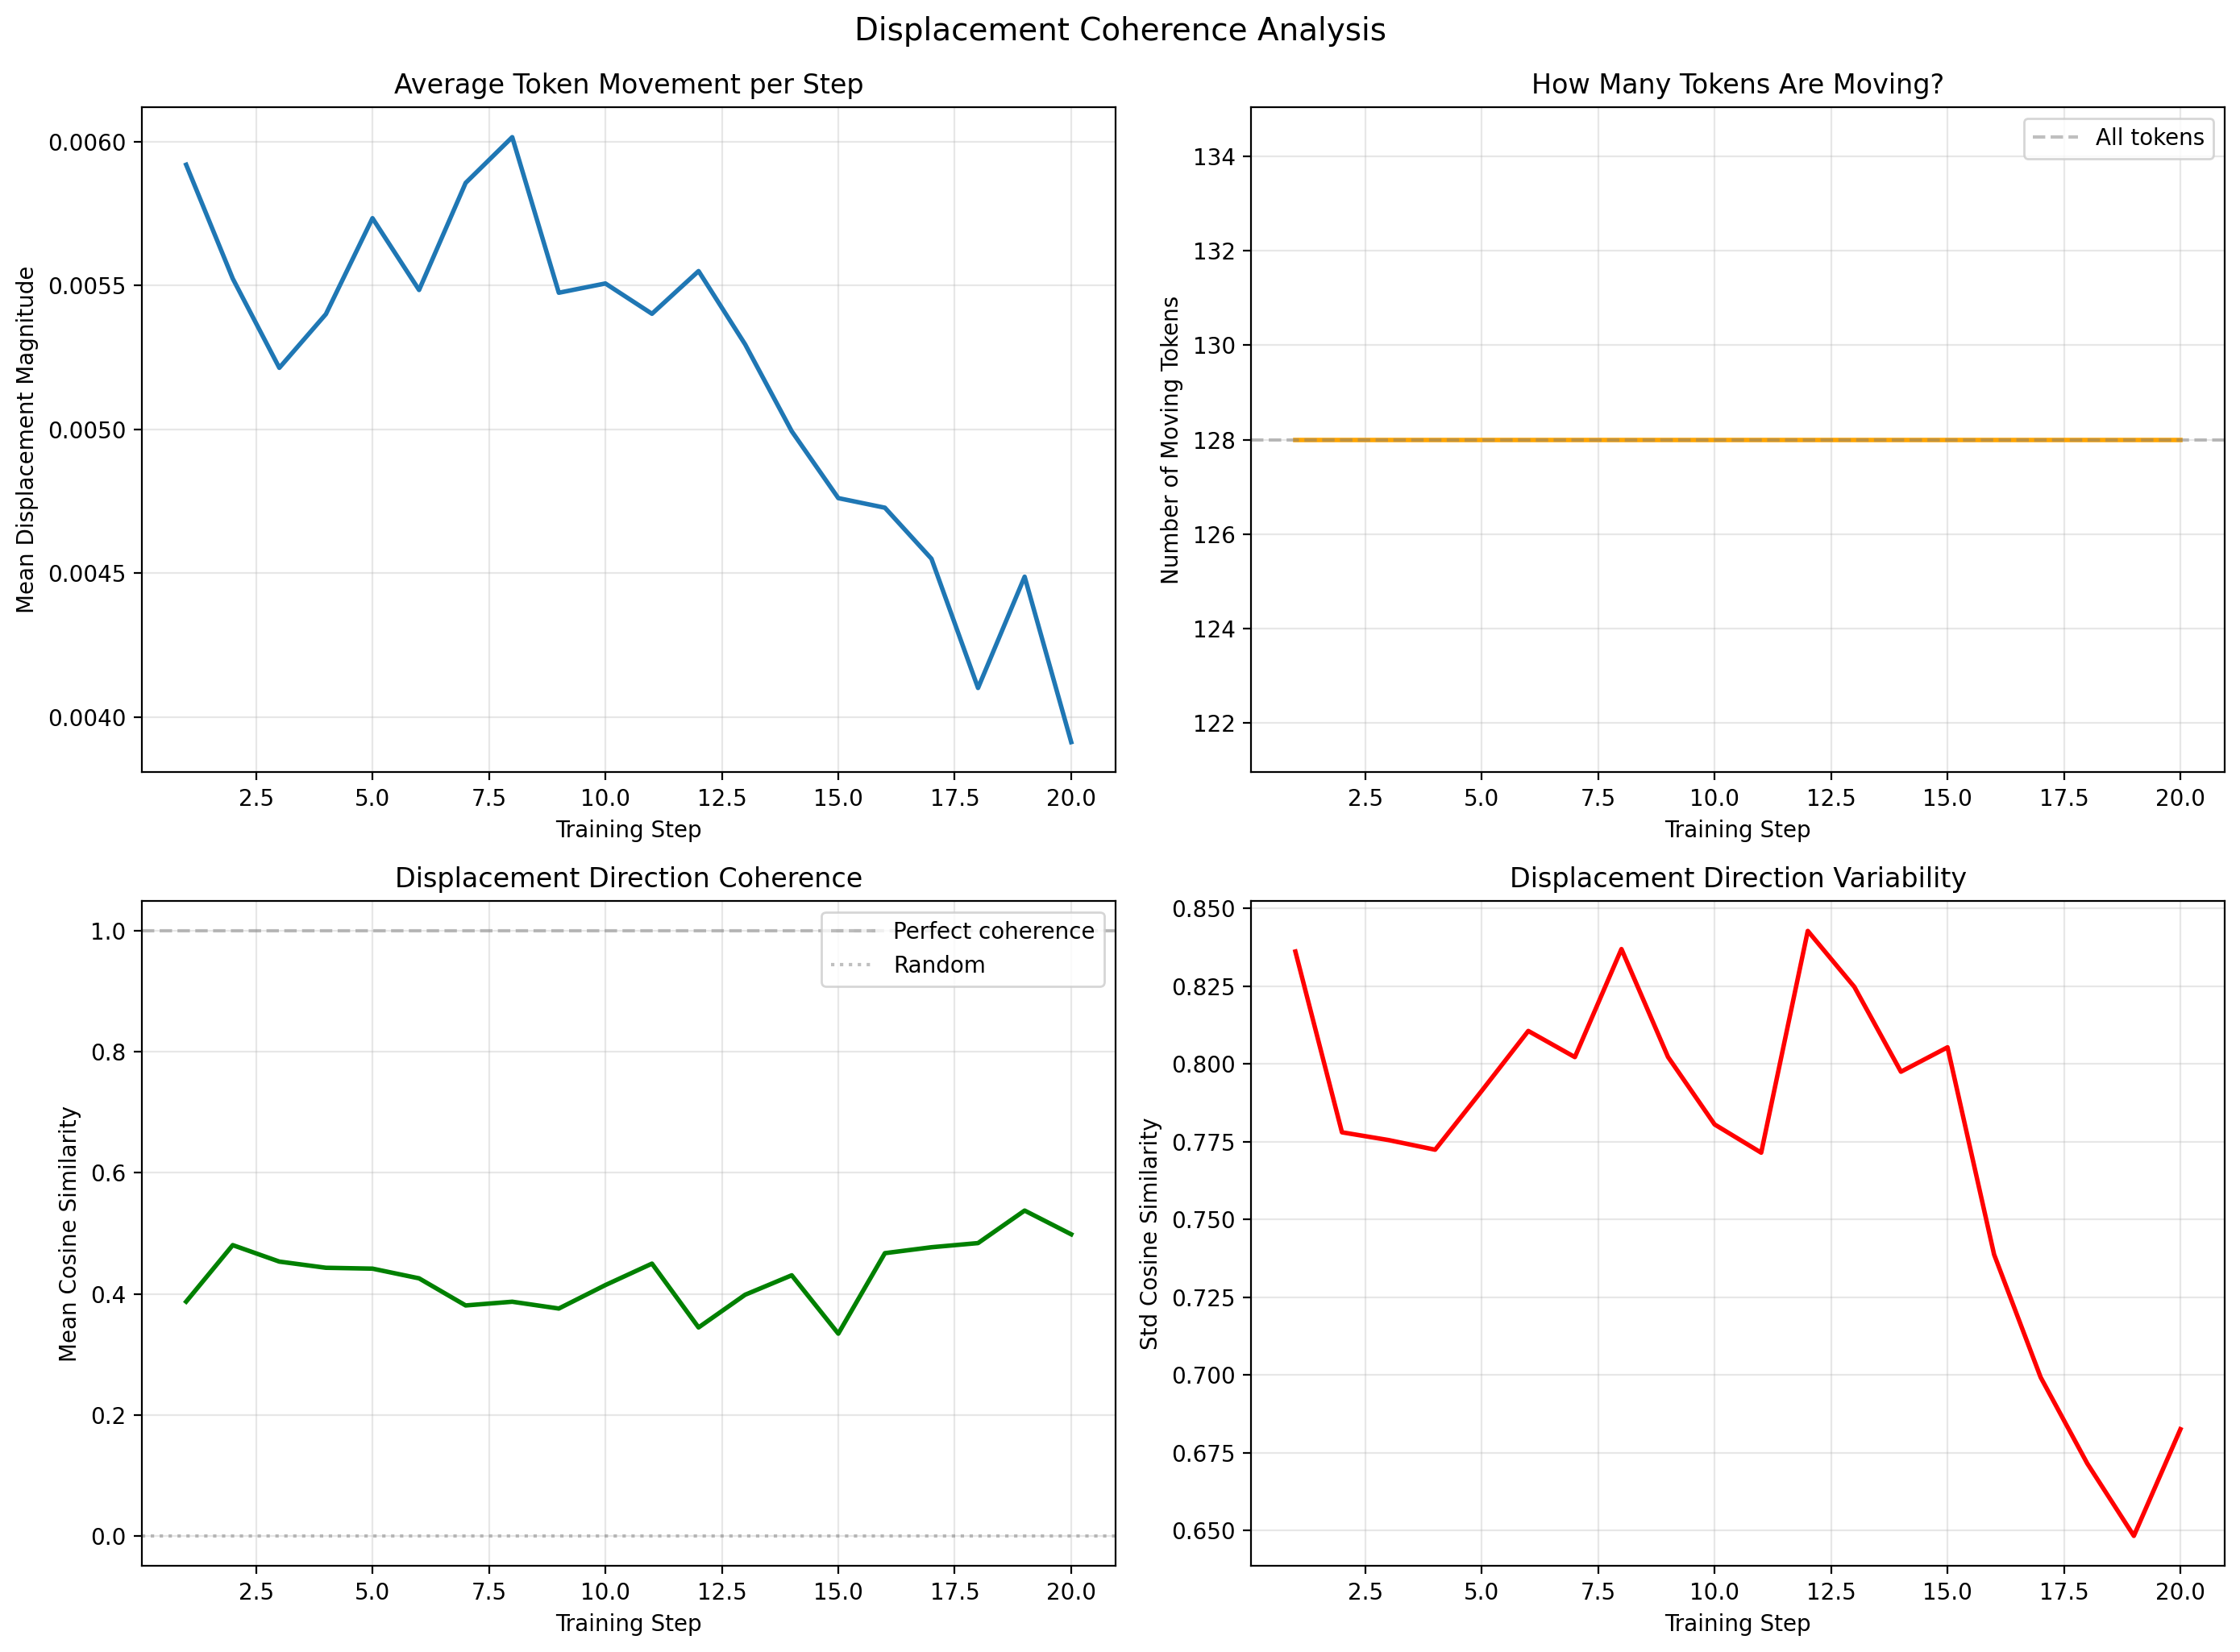

In [31]:
# Plot coherence over time
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=DPI)

steps = [r['step'] for r in coherence_results]
mean_mag = [r['mean_magnitude'] for r in coherence_results]
n_moving = [r['n_moving'] for r in coherence_results]
mean_cos = [r['mean_cosine'] for r in coherence_results]
std_cos = [r['std_cosine'] for r in coherence_results]

# Mean displacement magnitude
ax = axes[0, 0]
ax.plot(steps, mean_mag, linewidth=2)
ax.set_xlabel('Training Step')
ax.set_ylabel('Mean Displacement Magnitude')
ax.set_title('Average Token Movement per Step')
ax.grid(alpha=0.3)

# Number of moving tokens
ax = axes[0, 1]
ax.plot(steps, n_moving, linewidth=2, color='orange')
ax.axhline(128, color='gray', linestyle='--', alpha=0.5, label='All tokens')
ax.set_xlabel('Training Step')
ax.set_ylabel('Number of Moving Tokens')
ax.set_title('How Many Tokens Are Moving?')
ax.legend()
ax.grid(alpha=0.3)

# Mean cosine similarity
ax = axes[1, 0]
ax.plot(steps, mean_cos, linewidth=2, color='green')
ax.axhline(1.0, color='gray', linestyle='--', alpha=0.5, label='Perfect coherence')
ax.axhline(0.0, color='gray', linestyle=':', alpha=0.5, label='Random')
ax.set_xlabel('Training Step')
ax.set_ylabel('Mean Cosine Similarity')
ax.set_title('Displacement Direction Coherence')
ax.legend()
ax.grid(alpha=0.3)

# Std cosine similarity
ax = axes[1, 1]
ax.plot(steps, std_cos, linewidth=2, color='red')
ax.set_xlabel('Training Step')
ax.set_ylabel('Std Cosine Similarity')
ax.set_title('Displacement Direction Variability')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.suptitle('Displacement Coherence Analysis', y=1.02, fontsize=14)
plt.show()

## 4. Effective Number of Movers

In [32]:
print('Computing effective number of movers...')
print()

# For each step, count how many tokens have moved >threshold from initial position
emb_init = embeddings[ANALYSIS_STEPS[0]].cpu().numpy()  # (128, 64)

n_movers = []
distances_from_init = []

for step in ANALYSIS_STEPS:
    emb = embeddings[step].cpu().numpy()
    
    # Distance of each token from its initial position
    dists = np.linalg.norm(emb - emb_init, axis=1)  # (128,)
    distances_from_init.append(dists)
    
    # Count movers
    movers = (dists > SIGNIFICANT_MOVEMENT).sum()
    n_movers.append(movers)

distances_from_init = np.array(distances_from_init)  # (n_steps, 128)

print(f'✓ Computed mover counts for {len(ANALYSIS_STEPS)} steps')
print(f'  Threshold: {SIGNIFICANT_MOVEMENT}')
print(f'  Initial movers: {n_movers[0]}')
print(f'  Final movers: {n_movers[-1]}')

Computing effective number of movers...

✓ Computed mover counts for 21 steps
  Threshold: 0.01
  Initial movers: 0
  Final movers: 128


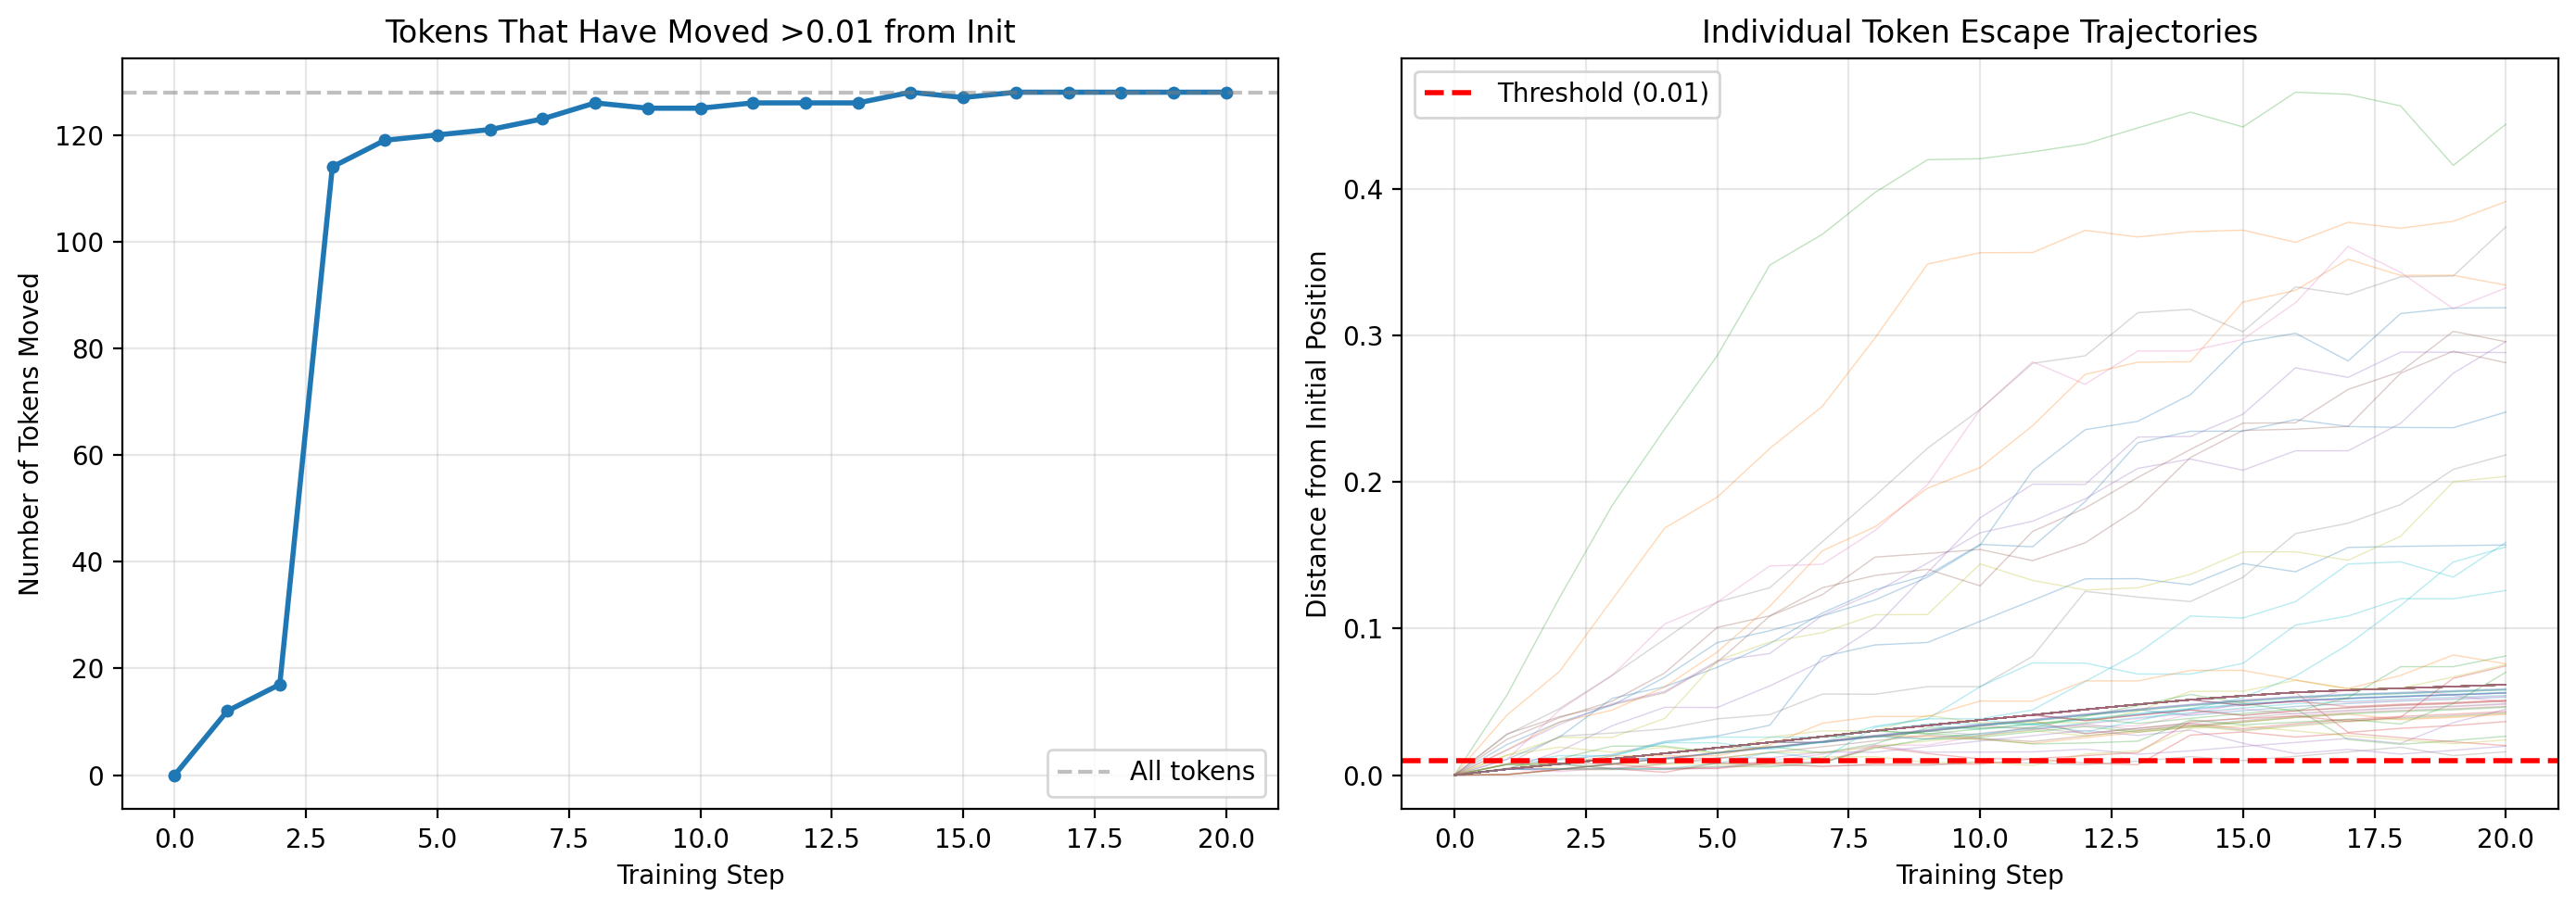

In [33]:
# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=DPI)

# Left: Number of movers over time
ax = axes[0]
ax.plot(ANALYSIS_STEPS, n_movers, linewidth=2, marker='o', markersize=4)
ax.axhline(128, color='gray', linestyle='--', alpha=0.5, label='All tokens')
ax.set_xlabel('Training Step')
ax.set_ylabel('Number of Tokens Moved')
ax.set_title(f'Tokens That Have Moved >{SIGNIFICANT_MOVEMENT} from Init')
ax.legend()
ax.grid(alpha=0.3)

# Right: Distance from init for all tokens
ax = axes[1]
for tok_idx in range(n_tokens):
    ax.plot(ANALYSIS_STEPS, distances_from_init[:, tok_idx], alpha=0.3, linewidth=0.5)

# Overlay threshold
ax.axhline(SIGNIFICANT_MOVEMENT, color='r', linestyle='--', linewidth=2, label=f'Threshold ({SIGNIFICANT_MOVEMENT})')
ax.set_xlabel('Training Step')
ax.set_ylabel('Distance from Initial Position')
ax.set_title('Individual Token Escape Trajectories')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Neighbor Preservation

In [34]:
print('Computing neighbor preservation...')
print()

# Strategy: Compare initial distance matrix to final distance matrix
# If neighbors are preserved, rank order should be similar
# Use Spearman correlation for each token's distance vector

emb_init = embeddings[ANALYSIS_STEPS[0]].cpu().numpy()
emb_final = embeddings[ANALYSIS_STEPS[-1]].cpu().numpy()

# Distance matrices
dist_init_vec = pdist(emb_init, metric='euclidean')
dist_final_vec = pdist(emb_final, metric='euclidean')

dist_init_mat = squareform(dist_init_vec)
dist_final_mat = squareform(dist_final_vec)

# For each token, compute Spearman correlation of its distance vector
# (how it ranks other tokens by distance)
spearman_correlations = []

for tok_idx in range(n_tokens):
    init_dists = dist_init_mat[tok_idx, :]
    final_dists = dist_final_mat[tok_idx, :]
    
    # Remove self (distance 0)
    mask = np.arange(n_tokens) != tok_idx
    init_dists = init_dists[mask]
    final_dists = final_dists[mask]
    
    # Spearman correlation
    corr, _ = spearmanr(init_dists, final_dists)
    spearman_correlations.append(corr)

spearman_correlations = np.array(spearman_correlations)

print(f'✓ Computed neighbor preservation for {n_tokens} tokens')
print(f'  Mean Spearman correlation: {spearman_correlations.mean():.4f}')
print(f'  Std: {spearman_correlations.std():.4f}')
print()
print('Interpretation:')
print('  - Correlation ≈ 1.0  → neighbors preserved (orderly sublimation)')
print('  - Correlation ≈ 0.0  → neighbors scrambled (thermal evaporation)')

Computing neighbor preservation...

✓ Computed neighbor preservation for 128 tokens
  Mean Spearman correlation: 0.1881
  Std: 0.1890

Interpretation:
  - Correlation ≈ 1.0  → neighbors preserved (orderly sublimation)
  - Correlation ≈ 0.0  → neighbors scrambled (thermal evaporation)


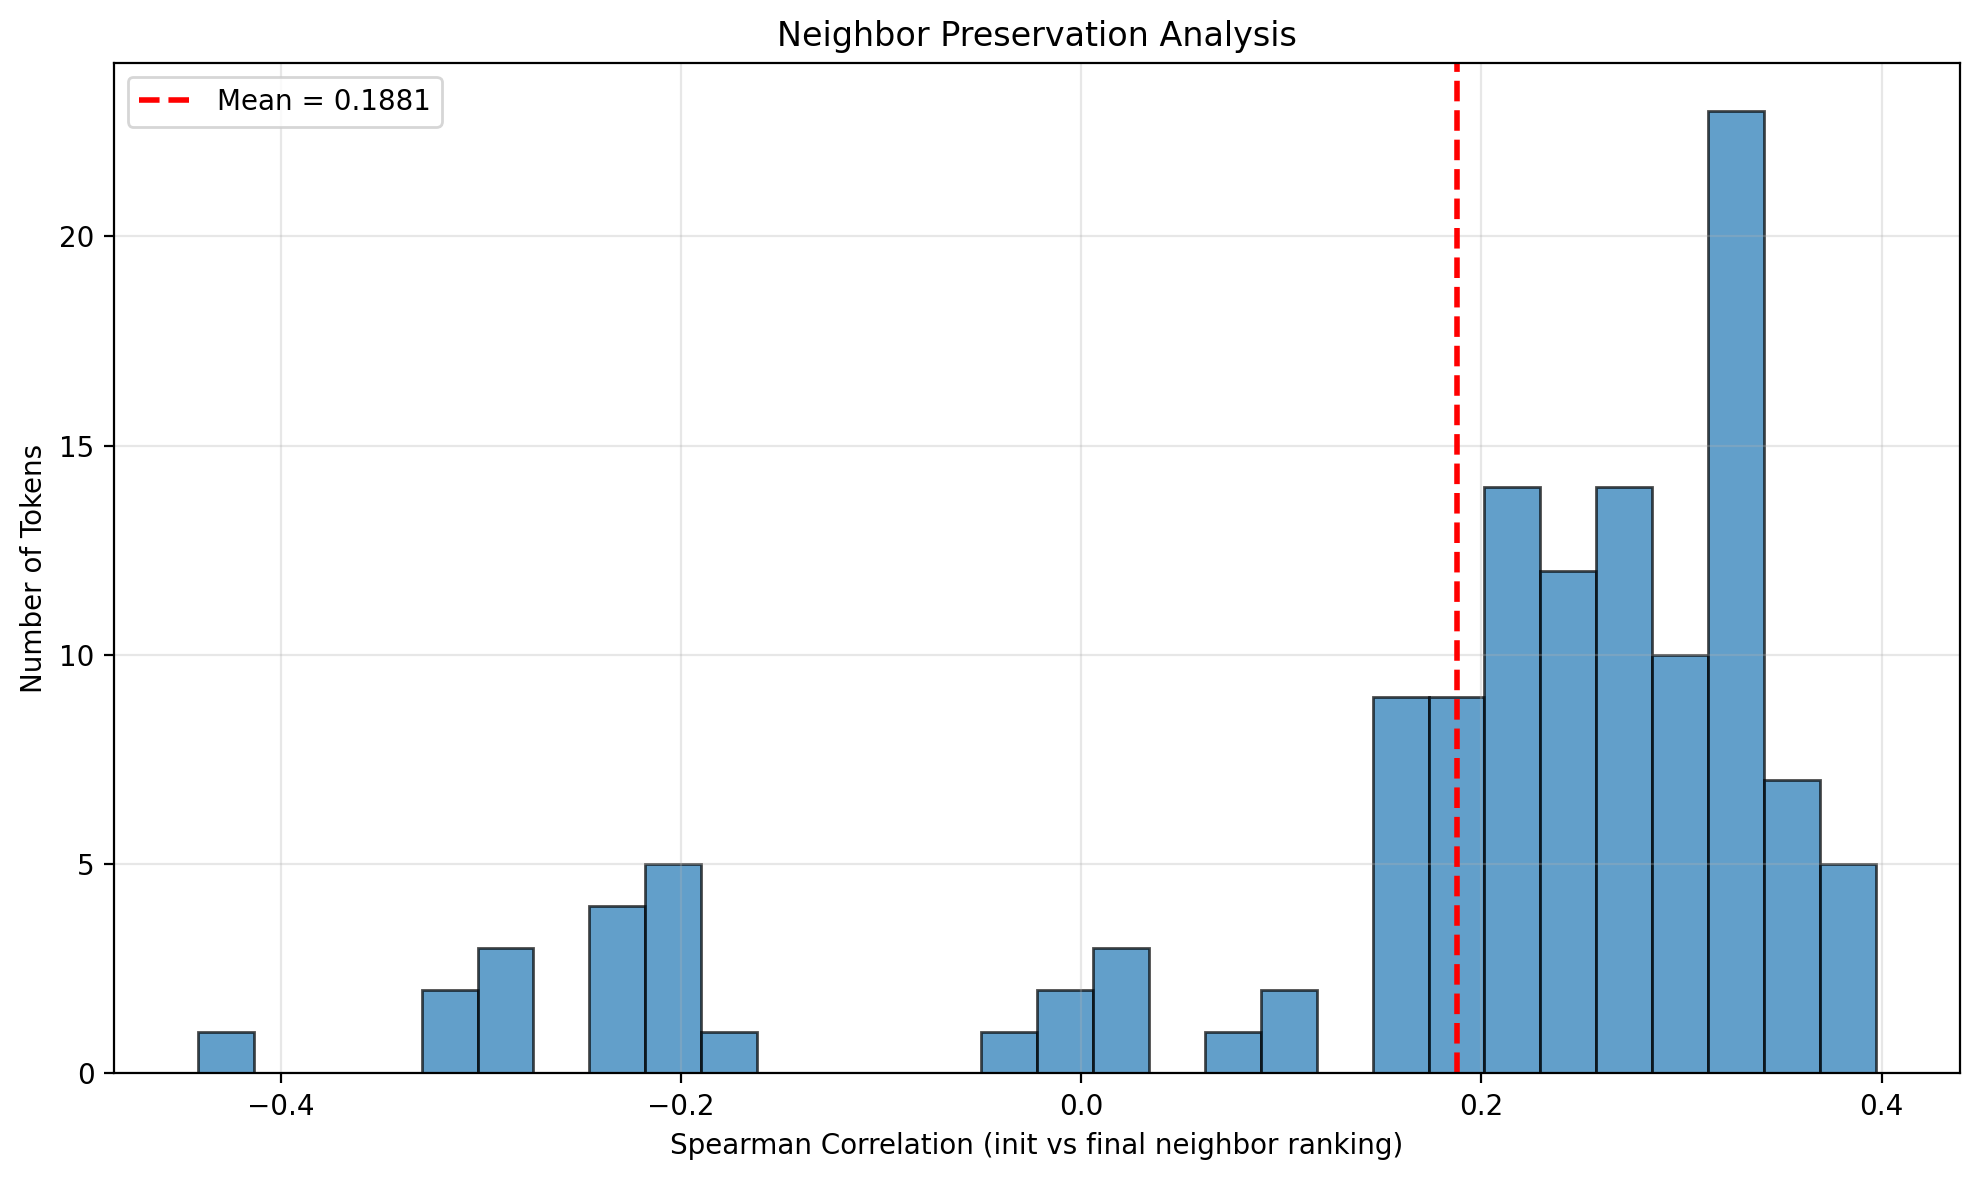

In [35]:
# Plot distribution of Spearman correlations
fig, ax = plt.subplots(figsize=(10, 6), dpi=DPI)

ax.hist(spearman_correlations, bins=30, edgecolor='black', alpha=0.7)
ax.axvline(spearman_correlations.mean(), color='r', linestyle='--', linewidth=2, 
           label=f'Mean = {spearman_correlations.mean():.4f}')
ax.set_xlabel('Spearman Correlation (init vs final neighbor ranking)')
ax.set_ylabel('Number of Tokens')
ax.set_title('Neighbor Preservation Analysis')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Final Verdict

In [36]:
print('='*70)
print('PRIMORDIAL ATOM BREAKUP: FINAL VERDICT')
print('='*70)
print()
print(f'Analysis of {RUN_NAME}')
print(f'Steps {ANALYSIS_STEPS[0]}-{ANALYSIS_STEPS[-1]}')
print()

# Cluster expansion
print('1. CLUSTER EXPANSION:')
initial_mean_radius = radius[0].mean()
final_mean_radius = radius[-1].mean()
expansion_factor = final_mean_radius / initial_mean_radius if initial_mean_radius > 0 else np.inf
print(f'   Mean radius grew {expansion_factor:.2f}x (from {initial_mean_radius:.6f} to {final_mean_radius:.6f})')
print()

# Pairwise distances
print('2. PAIRWISE STRUCTURE:')
init_dist_mean = dist_matrices[0].mean()
final_dist_mean = dist_matrices[-1].mean()
print(f'   Mean pairwise distance: {init_dist_mean:.6f} → {final_dist_mean:.6f}')
print()

# Displacement coherence
print('3. DISPLACEMENT COHERENCE:')
mean_coherence = np.nanmean([r['mean_cosine'] for r in coherence_results])
print(f'   Average cosine similarity: {mean_coherence:.4f}')
if mean_coherence > 0.8:
    verdict_coherence = 'COHERENT (all tokens moving same direction)'
elif mean_coherence < 0.2:
    verdict_coherence = 'THERMAL (random uncorrelated directions)'
else:
    verdict_coherence = 'MIXED (partially coherent)'
print(f'   Verdict: {verdict_coherence}')
print()

# Effective movers
print('4. ESCAPE DYNAMICS:')
print(f'   Tokens moved >{SIGNIFICANT_MOVEMENT}: {n_movers[0]} → {n_movers[-1]}')
if n_movers[-1] >= 0.9 * n_tokens:
    verdict_movers = 'COLLECTIVE (most/all tokens moving)'
elif n_movers[-1] <= 0.2 * n_tokens:
    verdict_movers = 'ONE-BY-ONE (few tokens escaping)'
else:
    verdict_movers = 'GRADUAL (progressive escape)'
print(f'   Verdict: {verdict_movers}')
print()

# Neighbor preservation
print('5. NEIGHBOR PRESERVATION:')
mean_spearman = spearman_correlations.mean()
print(f'   Mean Spearman correlation: {mean_spearman:.4f}')
if mean_spearman > 0.7:
    verdict_neighbors = 'PRESERVED (orderly sublimation)'
elif mean_spearman < 0.3:
    verdict_neighbors = 'SCRAMBLED (thermal evaporation)'
else:
    verdict_neighbors = 'PARTIALLY PRESERVED'
print(f'   Verdict: {verdict_neighbors}')
print()

print('='*70)
print('OVERALL MECHANISM:')
print()
if mean_coherence > 0.8 and mean_spearman > 0.7:
    print('→ COHERENT EXPANSION: Tokens move together in structured way')
elif mean_coherence < 0.2 and mean_spearman < 0.3:
    print('→ BROWNIAN EVAPORATION: Thermal diffusion, random directions')
elif n_movers[-1] <= 0.2 * n_tokens and mean_spearman > 0.7:
    print('→ ONE-BY-ONE SUBLIMATION: Orderly escape preserving structure')
else:
    print('→ MIXED REGIME: Combination of mechanisms')
print('='*70)

PRIMORDIAL ATOM BREAKUP: FINAL VERDICT

Analysis of 1.9d (vanilla SGD, lr=0.1, batch=1)
Steps 0-20

1. CLUSTER EXPANSION:
   Mean radius grew 287.19x (from 0.000285 to 0.081705)

2. PAIRWISE STRUCTURE:
   Mean pairwise distance: 0.000354 → 0.092174

3. DISPLACEMENT COHERENCE:
   Average cosine similarity: 0.4307
   Verdict: MIXED (partially coherent)

4. ESCAPE DYNAMICS:
   Tokens moved >0.01: 0 → 128
   Verdict: COLLECTIVE (most/all tokens moving)

5. NEIGHBOR PRESERVATION:
   Mean Spearman correlation: 0.1881
   Verdict: SCRAMBLED (thermal evaporation)

OVERALL MECHANISM:

→ MIXED REGIME: Combination of mechanisms
